# Подключение гугл диска

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Импорт библиотек

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Считывание данных

## train.csv

In [33]:
train = pd.read_csv('/content/drive/MyDrive/train1.csv')
train.head()

,ISU,ST_YEAR,SEMESTER,DISC_ID,TYPE_NAME,DEBT
0,17623928044460629977,2020,1,10502311854018326223,Зачет,0
1,17623928044460629977,2020,1,1601392918367593206,Зачет,0
2,17623928044460629977,2020,1,9559803959325174929,Зачет,0
3,17623928044460629977,2020,1,8955667882044263414,Зачет,0
4,17623928044460629977,2020,1,17741967398854095262,Экзамен,0


Таргет для обучения с оценками и количеством долгов студентов

- ISU - UID студента
- ST_YEAR - год получения оценки
- SEMESTER - семестр получения оценки
- DISC_ID - UID дисциплины
- TYPE_NAME - форма отчётности
- DEBT - факт наличия долга (0 - отсутствие, 1 - наличие) - таргет

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178899 entries, 0 to 178898
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISU        178899 non-null  uint64
 1   ST_YEAR    178899 non-null  int64 
 2   SEMESTER   178899 non-null  int64 
 3   DISC_ID    178899 non-null  uint64
 4   TYPE_NAME  178899 non-null  object
 5   DEBT       178899 non-null  int64 
dtypes: int64(3), object(1), uint64(2)
memory usage: 8.2+ MB


In [35]:
train.shape

(178899, 6)

## comp_portrait.csv

In [36]:
comp_portrait = pd.read_csv('/content/drive/MyDrive/comp_portrait.csv')
comp_portrait.head()

,ISU,GENDER,CITIZENSHIP,EXAM_TYPE,EXAM_SUBJECT_1,EXAM_SUBJECT_2,EXAM_SUBJECT_3,ADMITTED_EXAM_1,ADMITTED_EXAM_2,ADMITTED_EXAM_3,ADMITTED_SUBJECT_PRIZE_LEVEL,REGION_ID
0,8746993777733478780,Ж,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,88.0,91.0,81.0,ЕГЭ,4877310761925081124
1,18279003839105282485,М,15601729049989747827,ВИ,70786669040476600,5533732657842394915,8388269026169219461,84.0,89.0,96.0,ЕГЭ,4877310761925081124
2,17601399077733331421,М,15601729049989747827,ВИ,70786669040476600,5533732657842394915,8388269026169219461,66.0,78.0,93.0,ЕГЭ,4877310761925081124
3,4111128904589594590,М,15601729049989747827,ВИ,70786669040476600,5533732657842394915,8388269026169219461,100.0,89.0,80.0,ЕГЭ,4877310761925081124
4,5943608672516320930,М,15601729049989747827,ВИ,70786669040476600,5533732657842394915,8388269026169219461,84.0,86.0,91.0,ЕГЭ,4877310761925081124


- ISU - UID студента
- GENDER - пол
- CITIZENSHIP - гражданство
- EXAM_TYPE - форма зачисления (ЕГЭ, олимпиада, ВИ - вступительные испытания)
- EXAM_SUBJECT_1 - первый экзамен ЕГЭ
- EXAM_SUBJECT_2 - второй экзамен ЕГЭ
- EXAM_SUBJECT_3 - третий экзамен ЕГЭ
- ADMITTED_EXAM_1 - баллы за 1 экзамен ЕГЭ
- ADMITTED_EXAM_2 - баллы за 2 экзамен ЕГЭ
- ADMITTED_EXAM_3 - баллы за 3 экзамен ЕГЭ
- ADMITTED_SUBJECT_PRIZE_LEVEL - уровень олимпиады (если есть)
- REGION_ID - номер региона

In [37]:
comp_portrait.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8583 entries, 0 to 8582
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ISU                           8583 non-null   uint64 
 1   GENDER                        8583 non-null   object 
 2   CITIZENSHIP                   8583 non-null   uint64 
 3   EXAM_TYPE                     8582 non-null   object 
 4   EXAM_SUBJECT_1                8583 non-null   uint64 
 5   EXAM_SUBJECT_2                8583 non-null   uint64 
 6   EXAM_SUBJECT_3                8583 non-null   uint64 
 7   ADMITTED_EXAM_1               7404 non-null   float64
 8   ADMITTED_EXAM_2               7404 non-null   float64
 9   ADMITTED_EXAM_3               7404 non-null   float64
 10  ADMITTED_SUBJECT_PRIZE_LEVEL  8583 non-null   object 
 11  REGION_ID                     8583 non-null   uint64 
dtypes: float64(3), object(3), uint64(6)
memory usage: 804.8+ KB


Видим пропущенные значения, обработаем их позже

In [38]:
comp_portrait.shape

(8583, 12)

Присоединим comp_portrait к df

In [39]:
df = pd.merge(train, comp_portrait, on='ISU')
df.head()

,ISU,ST_YEAR,SEMESTER,DISC_ID,TYPE_NAME,DEBT,GENDER,CITIZENSHIP,EXAM_TYPE,EXAM_SUBJECT_1,EXAM_SUBJECT_2,EXAM_SUBJECT_3,ADMITTED_EXAM_1,ADMITTED_EXAM_2,ADMITTED_EXAM_3,ADMITTED_SUBJECT_PRIZE_LEVEL,REGION_ID
0,17623928044460629977,2020,1,10502311854018326223,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082
1,17623928044460629977,2020,1,1601392918367593206,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082
2,17623928044460629977,2020,1,9559803959325174929,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082
3,17623928044460629977,2020,1,8955667882044263414,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082
4,17623928044460629977,2020,1,17741967398854095262,Экзамен,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082


In [40]:
df.shape

(178899, 17)

## comp_marks.csv

In [41]:
comp_marks = pd.read_csv('/content/drive/MyDrive/comp_marks.csv')
comp_marks.drop_duplicates(inplace=True)
comp_marks.head()

,ISU,ST_YEAR,SEMESTER,TYPE_NAME,MARK,MAIN_PLAN,DISC_ID,PRED_ID
0,17623928044460629977,2020,1,Зачет,зачет,4664712865904477750,10502311854018326223,5087927234000983963
1,17623928044460629977,2020,1,Зачет,зачет,4664712865904477750,1601392918367593206,5087927234000983963
2,17623928044460629977,2020,1,Зачет,зачет,4664712865904477750,9559803959325174929,5087927234000983963
3,17623928044460629977,2020,1,Зачет,зачет,4664712865904477750,8955667882044263414,5087927234000983963
4,17623928044460629977,2020,1,Экзамен,3,4664712865904477750,17741967398854095262,5087927234000983963


- ISU - UID студента
- ST_YEAR - год начала курса (первое число из формата 2020/2021)
- SEMESTER - фактический семестр, в котором получена оценка
- TYPE_NAME - форма отчетности
- MARK - оценка (или зачет/незачет)
- MAIN_PLAN - учебный план
- DISC_ID - UID дисциплины
- PRED_ID - UID преподавателя

In [42]:
comp_marks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182793 entries, 0 to 182794
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISU        182793 non-null  uint64
 1   ST_YEAR    182793 non-null  int64 
 2   SEMESTER   182793 non-null  int64 
 3   TYPE_NAME  182793 non-null  object
 4   MARK       182206 non-null  object
 5   MAIN_PLAN  182793 non-null  uint64
 6   DISC_ID    182793 non-null  uint64
 7   PRED_ID    182793 non-null  uint64
dtypes: int64(2), object(2), uint64(4)
memory usage: 12.6+ MB


In [43]:
comp_marks.shape

(182793, 8)

Видим, что в столбце MARK есть пропущенные значения. Заполнять target статистиками не очень хочется, поэтому просто удалим эти строки

In [44]:
comp_marks.dropna(inplace=True)

Проверим, уникально ли идентифицируется каждая строка полями ISU, DISC_ID, SEMESTER, ST_YEAR, TYPE_NAME и MARK

In [45]:
test = pd.DataFrame(comp_marks.groupby(by=['ISU', 'DISC_ID', 'SEMESTER', 
                                           'ST_YEAR', 'TYPE_NAME', 'MARK']).size())
test[test[0]>1]

0
ISU                  DISC_ID              SEMESTER ST_YEAR TYPE_NAME MARK    
89667946269696082    3974502934019510056  1        2019    Экзамен   4      2
                     7454837725181691115  1        2019    Экзамен   3      2
                     7835846297793492094  1        2019    Зачет     зачет  2
                     9028324525774925341  1        2019    Зачет     зачет  2
100263122180698976   1601392918367593206  1        2018    Зачет     зачет  2
...                                                                        ..
18403892705421388107 7835846297793492094  2        2019    Зачет     зачет  2
                     9028324525774925341  1        2019    Зачет     зачет  2
                                          2        2019    Зачет     зачет  2
                     13199182807431031308 2        2019    Экзамен   3      2
                     13789771458674529179 2        2019    Зачет     зачет  2

[6250 rows x 1 columns]

Видим, что нет. Взглянем на первый объект, чтобы лучше понять, что это означает

In [46]:
comp_marks[
    (comp_marks['SEMESTER'] == 1) &
    (comp_marks['DISC_ID'] == 3974502934019510056) &
    (comp_marks['ST_YEAR'] == 2019) &
    (comp_marks['TYPE_NAME'] == 'Экзамен') &
    (comp_marks['ISU'] == 89667946269696082)
]

,ISU,ST_YEAR,SEMESTER,TYPE_NAME,MARK,MAIN_PLAN,DISC_ID,PRED_ID
32429,89667946269696082,2019,1,Экзамен,4,10080731777079285074,3974502934019510056,5087927234000983963
41656,89667946269696082,2019,1,Экзамен,4,10782470634773039372,3974502934019510056,10404421190345341785


Объекты различаются по полям PRED_ID и MAIN_PLAN. В принципе, такая ситуация возможна, если, например, предмет принимают два преподавателя, а также если один предмет принадлежит разным учебным планам.

Если заглянуть в файл baseline, предоставленный организаторами соревнования, можно увидеть, что в качестве уникального идентификатора попытки они используют 5 полей (те самые поля, которые включены в train за исключением target-метки). Это значит, что если объекты по этим 5 полям, а также в target-метке совпадают, то мы можем смело говорить о том, что они описывают одну и ту же попытку.

Нам нужно каким-то образом схлопнуть такие объекты в один - как вариант, использовать бинаризацию, а затем группировку с суммированием по соотвутствующим столбцам. Так, в нашем случае будет уже не два объекта, а один, в котором будут проставлены единицы в признаках MAIN_PLAN_10080731777079285074, MAIN_PLAN_10782470634773039372, PRED_ID_5087927234000983963 и PRED_ID_10404421190345341785, а во всех других бинарных признаках - нули.

Проблема состоит в том, что джоинить потом по бинаризованным столбцам - та ещё задачка. Поэтому посмотрим для начала датафрейм comp_disc, а затем вернёмся к этому этапу

## comp_disc.csv

In [47]:
comp_disc = pd.read_csv('/content/drive/MyDrive/comp_disc.csv')
comp_disc.head()

,PLAN_ID,DISC_ID,СHOICE,SEMESTER,DISC_NAME,DISC_DEP,KEYWORD_NAMES
0,13019929768422386211,12540082885330665258,1.0,6.0,Методы криптографии,8139328495281102994,"криптография, криптография, криптография, клас..."
1,13019929768422386211,8471500331110227546,1.0,6.0,Анализ социальных сетей,8139328495281102994,"технологии работы информацией, алгоритмы обраб..."
2,13019929768422386211,11786710099399385350,1.0,6.0,Эффективное участие в научных и практических к...,1687590892619214362,NaN
3,13019929768422386211,18074319180892552096,1.0,6.0,Управление карьерой,1687590892619214362,NaN
4,13019929768422386211,17709308778630417516,1.0,6.0,Обработка изображений,8139328495281102994,"классическое машинное обучение, генерация изоб..."


- PLAN_ID - UID учебного плана (то же что и MAIN_PLAN - значения в этих колонках соответствуют друг другу и могут быть использованы для сопоставления таблиц)
- DISC_ID - UID дисциплины
- СHOICE - выборность дисциплины
- SEMESTER - семестр проведения дисциплины в данном учебном плане
- DISC_NAME - название дисциплины
- DISC_DEP - факультет-реализатор дисциплины

In [48]:
comp_disc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22517 entries, 0 to 22516
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PLAN_ID        22517 non-null  uint64 
 1   DISC_ID        22517 non-null  uint64 
 2   СHOICE         22517 non-null  float64
 3   SEMESTER       22517 non-null  float64
 4   DISC_NAME      22517 non-null  object 
 5   DISC_DEP       22517 non-null  uint64 
 6   KEYWORD_NAMES  13759 non-null  object 
dtypes: float64(2), object(2), uint64(3)
memory usage: 1.2+ MB


In [49]:
comp_disc.shape

(22517, 7)

Удалим столбец DISC_NAME, т.к. у нас уже есть DISC_ID, а также столбец KEYWORD_NAMES, т.к. он содержит почти половину пропущенных значений

In [50]:
comp_disc.drop(columns=['DISC_NAME', 'KEYWORD_NAMES'], inplace=True)

Удалим образовавшиеся дубликаты (строки, которые отличались только по полю KEYWORD_NAMES)

In [51]:
comp_disc.drop_duplicates(inplace=True)

Проверим, уникально ли идентифицируется каждая строка полями PLAN_ID, DISC_ID и SEMESTER

In [52]:
test = pd.DataFrame(comp_disc.groupby(by=['PLAN_ID', 'DISC_ID', 'SEMESTER']).size())
test[test[0]>1]

0
PLAN_ID             DISC_ID             SEMESTER   
5928068423167434299 8803870721775400102 1.0       2
9525771375887488353 7808003831249892566 2.0       2
                    8669037893956957554 2.0       2

Видим, что нет. Отдельно посмотрим на эти строки

In [53]:
comp_disc[
    (comp_disc['PLAN_ID'] == 5928068423167434299) &
    (comp_disc['DISC_ID'] == 8803870721775400102) &
    (comp_disc['SEMESTER'] == 1.0) &
    (comp_disc['DISC_DEP'] == 8738509941414530019)
]

,PLAN_ID,DISC_ID,СHOICE,SEMESTER,DISC_DEP
19944,5928068423167434299,8803870721775400102,1.0,1.0,8738509941414530019
19945,5928068423167434299,8803870721775400102,0.0,1.0,8738509941414530019


In [54]:
comp_disc[
    (comp_disc['PLAN_ID'] == 9525771375887488353) &
    (comp_disc['DISC_ID'] == 7808003831249892566) &
    (comp_disc['SEMESTER'] == 2.0) &
    (comp_disc['DISC_DEP'] == 8738509941414530019)
]

,PLAN_ID,DISC_ID,СHOICE,SEMESTER,DISC_DEP
13864,9525771375887488353,7808003831249892566,1.0,2.0,8738509941414530019
13865,9525771375887488353,7808003831249892566,0.0,2.0,8738509941414530019


In [55]:
comp_disc[
    (comp_disc['PLAN_ID'] == 9525771375887488353) &
    (comp_disc['DISC_ID'] == 8669037893956957554) &
    (comp_disc['SEMESTER'] == 2.0) &
    (comp_disc['DISC_DEP'] == 8738509941414530019)
]

,PLAN_ID,DISC_ID,СHOICE,SEMESTER,DISC_DEP
13862,9525771375887488353,8669037893956957554,1.0,2.0,8738509941414530019
13863,9525771375887488353,8669037893956957554,0.0,2.0,8738509941414530019


Таким образом, в этих парах строки различаются только по признаку CHOICE. Они противоречат друг другу, поэтому удалим их

In [56]:
comp_disc.drop(df.index[[19944, 19945, 13864, 13865, 13862, 13863]], inplace=True)

Ещё раз проверим, что столбцы PLAN_ID, DISC_ID и SEMESTER уникально идентифицируют каждую строку

In [57]:
test = pd.DataFrame(comp_disc.groupby(by=['PLAN_ID', 'DISC_ID', 'SEMESTER']).size())
test[test[0]>1]

,,,0
PLAN_ID,DISC_ID,SEMESTER,


Видим, что всё в порядке

Присоединим comp_disc к comp_marks

In [58]:
comp_disc.rename(columns={"PLAN_ID": "MAIN_PLAN"}, inplace=True)

comp_marks = pd.merge(comp_marks, comp_disc, on=['SEMESTER', 'DISC_ID', 'MAIN_PLAN'])
comp_marks.head()

,ISU,ST_YEAR,SEMESTER,TYPE_NAME,MARK,MAIN_PLAN,DISC_ID,PRED_ID,СHOICE,DISC_DEP
0,17623928044460629977,2020,1,Зачет,зачет,4664712865904477750,10502311854018326223,5087927234000983963,0.0,5077682191738720383
1,16373558259905320371,2020,1,Зачет,зачет,4664712865904477750,10502311854018326223,4153126429887436865,0.0,5077682191738720383
2,9464810043552925003,2020,1,Зачет,зачет,4664712865904477750,10502311854018326223,4153126429887436865,0.0,5077682191738720383
3,15871173322760135366,2020,1,Зачет,зачет,4664712865904477750,10502311854018326223,4153126429887436865,0.0,5077682191738720383
4,5765721226963909264,2020,1,Зачет,зачет,4664712865904477750,10502311854018326223,4153126429887436865,0.0,5077682191738720383


In [59]:
comp_marks.shape

(182198, 10)

## Бинаризация

Итак, вернёимя к comp_marks и бинаризуем столбцы MAIN_PLAN и PRED_ID

In [60]:
comp_marks = pd.get_dummies(data=comp_marks, columns=['MAIN_PLAN', 'PRED_ID', 'СHOICE', 'DISC_DEP'])

Теперь схлопнем все неуникальные по оставшимся признакам строки в одну, чтобы добиться нужного эффекта

In [61]:
comp_marks = pd.DataFrame(comp_marks.
                          groupby(by=['ISU', 'ST_YEAR', 'SEMESTER', 'TYPE_NAME',
                                      'DISC_ID', 'MARK']).sum())

У нас могли получиться не бинарные фичи, поэтому заменим все положительные целые числа в ячейках на 1

In [62]:
comp_marks = comp_marks.applymap(lambda x: 1 if x>0 else 0)

Теперь нужно поработать с target-меткой. Посмотрим, какие конкретно значения в ней лежат

In [63]:
comp_marks.reset_index(inplace=True)
comp_marks['MARK'].unique()

array(['зачет', '4', '5', '3', 'осв', '2', 'незач', 'неявка'],
      dtype=object)

Удалим строки со значением 'осв', т.к. они не говорят о наличии или отсутствии задолженности. Как правило, в вузах в таких случаях дают дополнительную попытку

In [64]:
comp_marks = comp_marks[comp_marks['MARK'] != 'осв']

Преобразуем столбец MARK

In [65]:
comp_marks['MARK'] =comp_marks['MARK'].apply(lambda x:
                                             1 if x in [2, 'незач', 'неявка'] else 0)
comp_marks.rename(columns={"MARK": "DEBT"}, inplace=True)

<ipython-input-65-d982b895eb1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_marks['MARK'] =comp_marks['MARK'].apply(lambda x:
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [66]:
comp_marks['DEBT'].unique()

array([0, 1])

In [67]:
comp_marks.head()

,ISU,ST_YEAR,SEMESTER,TYPE_NAME,DISC_ID,DEBT,MAIN_PLAN_5283359639739198,MAIN_PLAN_146705075719526806,MAIN_PLAN_268128140399877465,MAIN_PLAN_552722027248308867,...,DISC_DEP_12719755822715044906,DISC_DEP_12779834774062657273,DISC_DEP_12795149246808839444,DISC_DEP_12866670834530293829,DISC_DEP_12896073176567118977,DISC_DEP_13705271043836613455,DISC_DEP_16131140458546037814,DISC_DEP_16828277449727897492,DISC_DEP_17522523368314118110,DISC_DEP_18446744073709551615
0,999504425170639,2018,1,Зачет,1447999327144393299,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,999504425170639,2018,1,Зачет,1601392918367593206,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,999504425170639,2018,1,Зачет,7835846297793492094,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,999504425170639,2018,1,Зачет,9028324525774925341,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,999504425170639,2018,1,Курсовой проект,15184687608032834671,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Присоединим comp_marks к df

In [68]:
df = pd.merge(df, comp_marks, on=['ISU', 'ST_YEAR', 'SEMESTER', 'TYPE_NAME', 'DISC_ID', 'DEBT'])
df.head()

,ISU,ST_YEAR,SEMESTER,DISC_ID,TYPE_NAME,DEBT,GENDER,CITIZENSHIP,EXAM_TYPE,EXAM_SUBJECT_1,...,DISC_DEP_12719755822715044906,DISC_DEP_12779834774062657273,DISC_DEP_12795149246808839444,DISC_DEP_12866670834530293829,DISC_DEP_12896073176567118977,DISC_DEP_13705271043836613455,DISC_DEP_16131140458546037814,DISC_DEP_16828277449727897492,DISC_DEP_17522523368314118110,DISC_DEP_18446744073709551615
0,17623928044460629977,2020,1,10502311854018326223,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,...,0,0,0,0,0,0,0,0,0,0
1,17623928044460629977,2020,1,1601392918367593206,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,...,0,0,0,0,0,0,0,0,0,0
2,17623928044460629977,2020,1,9559803959325174929,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,...,0,0,0,0,0,0,0,0,0,0
3,17623928044460629977,2020,1,8955667882044263414,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,...,0,0,0,0,0,0,0,0,0,0
4,17623928044460629977,2020,1,17741967398854095262,Экзамен,0,М,15601729049989747827,ЕГЭ,70786669040476600,...,0,0,0,0,0,0,0,0,0,0


 # Знакомство с датафреймом + преобразования признаков

## Основная информация

Размер датафрейма

In [69]:
df.shape

(170890, 891)

Общая сводка

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170890 entries, 0 to 170889
Columns: 891 entries, ISU to DISC_DEP_18446744073709551615
dtypes: float64(3), int64(877), object(4), uint64(7)
memory usage: 1.1+ GB


## Заполнение пропусков

Помним, что у нас были пропуски в столбцах ADMITTED_EXAM. Это столбцы типа float. Заметим, что их значения - баллы за егэ, которые, вообще говоря, не могут быть дробными. Поэтому возьмём в качестве заполнителя медиану по всем значениям.

In [71]:
df.ADMITTED_EXAM_1  = df.ADMITTED_EXAM_1 .fillna(df.ADMITTED_EXAM_1.median())
df.ADMITTED_EXAM_2  = df.ADMITTED_EXAM_2.fillna(df.ADMITTED_EXAM_2.median())
df.ADMITTED_EXAM_3  = df.ADMITTED_EXAM_3 .fillna(df.ADMITTED_EXAM_3.median())

## Изменение типов столбцов

Признаки DISC_ID, TYPE_NAME, GENDER, CITIZENSHIP, EXAM_TYPE, EXAM_SUBJECT_1, EXAM_SUBJECT_2, EXAM_SUBJECT_3, ADMITTED_SUBJECT_PRIZE_LEVEL, REGION_ID являются категориальными. Приведем их к категориальному типу

In [72]:
for col in ['DISC_ID', 'TYPE_NAME', 'GENDER', 'CITIZENSHIP', 
            'EXAM_TYPE', 'EXAM_SUBJECT_1', 'EXAM_SUBJECT_2', 
            'EXAM_SUBJECT_3', 'ADMITTED_SUBJECT_PRIZE_LEVEL', 'REGION_ID']:
    
    df[col] = df[col].astype('category')

Посмотрим описательные статистики по float столбцам

In [73]:
df.describe(include=["float64"])

,ADMITTED_EXAM_1,ADMITTED_EXAM_2,ADMITTED_EXAM_3
count,170890.000000,170890.000000,170890.000000
mean,80.275341,82.608713,87.204412
std,9.437942,15.049345,8.802641
min,0.000000,0.000000,0.000000
25%,74.000000,79.000000,82.000000
50%,80.000000,84.000000,89.000000
75%,86.000000,91.000000,94.000000
max,100.000000,100.000000,100.000000


Посмотрим описательные статистики по category столбцам

In [74]:
df.describe(include="category")

,DISC_ID,TYPE_NAME,GENDER,CITIZENSHIP,EXAM_TYPE,EXAM_SUBJECT_1,EXAM_SUBJECT_2,EXAM_SUBJECT_3,ADMITTED_SUBJECT_PRIZE_LEVEL,REGION_ID
count,170890,170890,170890,170890,170890,170890,170890,170890,170890,170890
unique,946,4,2,11,3,6,8,5,6,85
top,9028324525774925341,Зачет,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,ЕГЭ,4877310761925081124
freq,11209,86996,115644,164710,137305,169444,124988,166176,131980,56395


# Exploratory data analysis

## Target

Посмотрим распределение целевой переменной

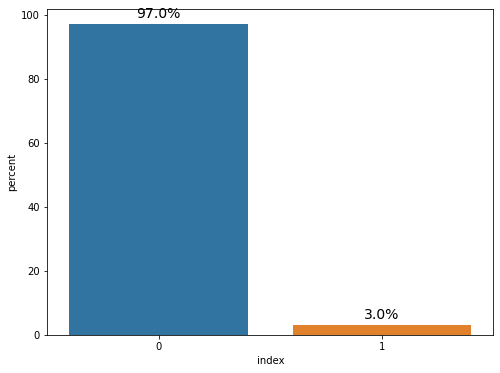

In [75]:
rcParams['figure.figsize'] = 8, 6

# Функция, добавляющая подпись процентов на график barplot
def plot_text(ax):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)
        
# Датафрейм частот значений      
norm_target = pd.DataFrame(df['DEBT'].value_counts(normalize=True).mul(100)\
                           .rename('percent')).reset_index()

ax = sns.barplot(x='index', y='percent', data=norm_target)
plot_text(ax)

Видим сильный дисбаланс классов, это нужно будет учесть при обучении алгоритма

Придумаем ряд гипотез, которые помогут нам лучше понять данные, и сразу же их проверим

## 1 гипотеза

Доля задолженностей у мужчин больше, чем у женщин (иными словами, вероятность того, что случайно выбранный объект с gender='М' будет принадлежать целевому классу больше вероятности того, что случайно выбранный объект с gender='Ж' будет принадлежать целевому классу)

<Figure size 864x5760 with 0 Axes>

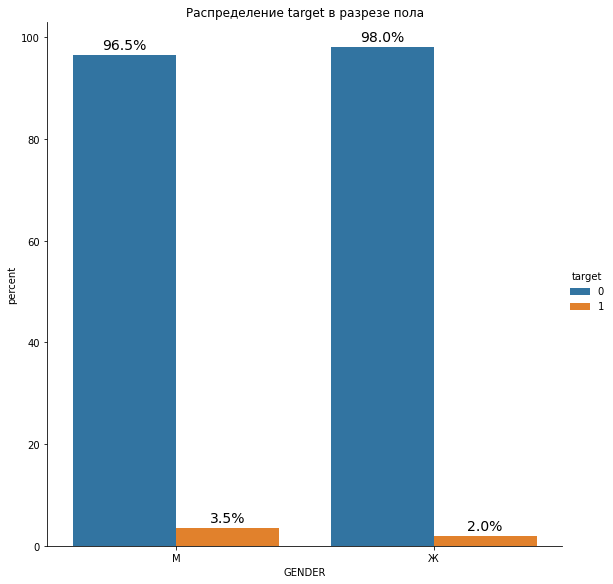

In [76]:
fig = plt.gcf()
fig.set_size_inches(12, 80)

rcParams['figure.figsize'] = 8, 6

temp_df_1 = df[df['GENDER']=='М']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_1['GENDER'] = ['М'] * len(temp_df_1)

temp_df_2 = df[df['GENDER']=='Ж']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_2['GENDER'] = ['Ж'] * len(temp_df_2)


target_values = pd.concat([temp_df_1, temp_df_2])
target_values.rename(columns={"index": "target"}, inplace=True)
target_values['percent']=target_values['percent']*100
          
g = sns.catplot(x='GENDER', y='percent', hue='target', data=target_values, kind='bar', height=8)
plt.title('Распределение target в разрезе пола')

plot_text(g.ax);

Видим, что доля попыток, закончившихся задолженностью у мужчин почти в 2 раза больше, чем у женщин. Гипотеза подтвердилась, и можно сделать вывод, что пол является важным признаком в нашей задаче

## 2 гипотеза

Доля задолженностей у олимпиадников меньше, чем у тех, кто сдавал ЕГЭ или вступительные испытания.

Это выглядит здравым предположением, так как задачи олимпиад обычно сложнее, и победители должны потратить на них много времени, параллельно готовясь к ЕГЭ/ ВИ. Даже людей, просто участвующих в олимпиадах обычно не очень много, и сложно представить, что те, кто в них побеждают, могут иметь плохие оценки в вузе

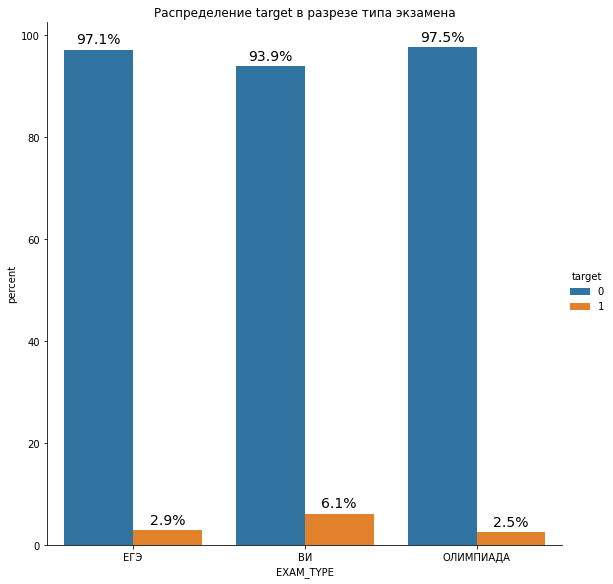

In [77]:
temp_df_1 = df[df['EXAM_TYPE']=='ЕГЭ']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_1['EXAM_TYPE'] = ['ЕГЭ'] * len(temp_df_1)

temp_df_2 = df[df['EXAM_TYPE']=='ВИ']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_2['EXAM_TYPE'] = ['ВИ'] * len(temp_df_1)

temp_df_3 = df[df['EXAM_TYPE']=='ОЛИМПИАДА']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_3['EXAM_TYPE'] = ['ОЛИМПИАДА'] * len(temp_df_1)

target_values = pd.concat([temp_df_1, temp_df_2, temp_df_3])
target_values.rename(columns={"index": "target"}, inplace=True)
target_values['percent']=target_values['percent']*100
          
g = sns.catplot(x='EXAM_TYPE', y='percent', hue='target', data=target_values, kind='bar', height=8)
plt.title('Распределение target в разрезе типа экзамена')

plot_text(g.ax);

Вторая гипотеза тоже подтвердилась - видим, что олимпиадники более успешны относительно других каст, хоть они и обогнали сдающих ЕГЭ всего на 0.4%. При этом, у людей, поступающих по вступительным испытаниям, доля неудач значительно выше

## 3 гипотеза

На экзаменах неудачи случаются чаще, чем на зачётах/диф. зачётах/при сдаче курсовых проектов

Экзамены в вузе, как правило, сложнее зачётов, и их нельзя сдавать много раз. Причём, в некоторых местах, если студент не сдал определённое кол-во зачётов, то к экзаменам его тоже не допустят. Аналогично, с курсовыми проектами - человек, не закрывший курсовую, автоматически получает 2 за экзамен. Поэтому логично предположить, что доля задолженностей выше для экзаменов, чем для других форм отчётности

In [78]:
df['TYPE_NAME'].unique()

['Зачет', 'Экзамен', 'Курсовой проект', 'Дифференцированный зачет']
Categories (4, object): ['Дифференцированный зачет', 'Зачет', 'Курсовой проект', 'Экзамен']

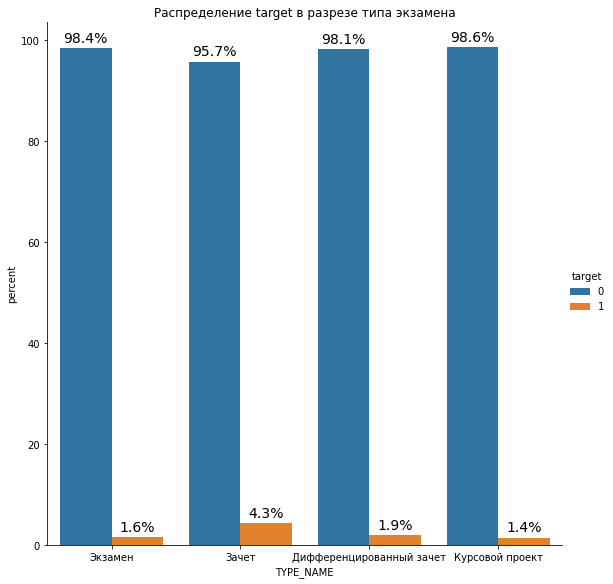

In [79]:
temp_df_1 = df[df['TYPE_NAME']=='Экзамен']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_1['TYPE_NAME'] = ['Экзамен'] * len(temp_df_1)

temp_df_2 = df[df['TYPE_NAME']=='Зачет']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_2['TYPE_NAME'] = ['Зачет'] * len(temp_df_2)

temp_df_3 = df[df['TYPE_NAME']=='Дифференцированный зачет']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_3['TYPE_NAME'] = ['Дифференцированный зачет'] * len(temp_df_3)
               
temp_df_4 = df[df['TYPE_NAME']=='Курсовой проект']['DEBT']\
                .value_counts(normalize=True).rename('percent').reset_index()
temp_df_4['TYPE_NAME'] = ['Курсовой проект'] * len(temp_df_4)
               

target_values = pd.concat([temp_df_1, temp_df_2, temp_df_3, temp_df_4])
target_values.rename(columns={"index": "target"}, inplace=True)
target_values['percent']=target_values['percent']*100
          
g = sns.catplot(x='TYPE_NAME', y='percent', hue='target',
                data=target_values, kind='bar', height=8)
plt.title('Распределение target в разрезе типа экзамена')

plot_text(g.ax);

Гипотеза не подтвердилась - видим, что наиболее проблемными являются зачёты, а наименее - курсовые проекты

## 4 гипотеза

Вероятность наличия задолженности обратно пропорциональна среднему баллу поступления. Иными словами, в разрезе target распределения среднего балла отличаются, при этом распределение для строк, соответствующих успешной попытке, должно быть смещено вправо (т.е. в сторону максимального балла)

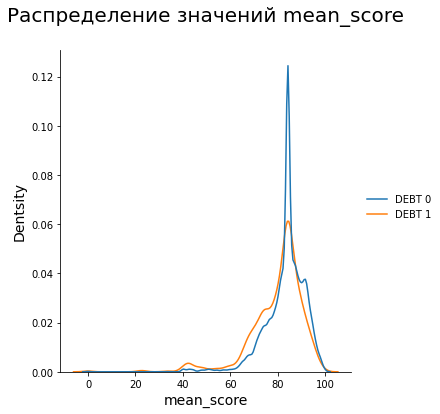

In [80]:
# Сформируем столбец среднего балла
df['mean_score'] = (df['ADMITTED_EXAM_1'] + df['ADMITTED_EXAM_2'] + df['ADMITTED_EXAM_3'])/3

sns.displot(
    data={
        "DEBT 0": df[df.DEBT == 0]['mean_score'],
        "DEBT 1": df[df.DEBT == 1]['mean_score']
    },
    kind="kde",
    common_norm=False,  
)

plt.title('Распределение значений mean_score\n', fontsize=20)
plt.xlabel('mean_score', fontsize=14)
plt.ylabel('Dentsity', fontsize=14);

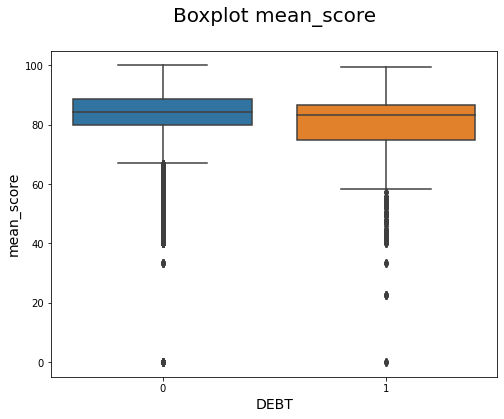

In [81]:
sns.boxplot(x='DEBT', y='mean_score', data=df)

plt.title('Boxplot mean_score\n', fontsize=20)
plt.ylabel('mean_score', fontsize=14)
plt.xlabel('DEBT', fontsize=14);

Гипотеза в принципе подтвердилась - по первому графику видно, что синее распределение смещено вправо. Это значит, что попытки, заканчивающиеся задолженностью, чаще приходятся на людей, имеющих меньшие баллы при поступлении. Боксплот также демонстрирует смещение статистик, хоть и не очень сильное

# Вывод и сохранение датафрейма

В целом, данные выглядят хорошо. Все признаки, которые мы исследовали, имеют какую-то связь с таргетом, а значит, будут полезными при обучении моделей

Выполним финальное преобразование - удалим признаки  'ISU' и 'ST_YEAR', так как мы не знаем их на новых данных, следовательно и при обучении они нам не понадобятся, после чего сохраним датафрейм для дальнейшего использования

In [82]:
df.drop(columns=['ISU', 'ST_YEAR'], inplace=True)

Сохраним в формате parquet, чтобы не терять типы столбцов

In [83]:
df.to_parquet('/content/data_test3.parquet.gzip')